# Deep Learning (AI5100)
## Assignment 4: <i>Recurrent Neural Networks</i>

<b>Name</b> - Sayanta Adhikari </br>
<b>Roll No</b> - AI22MTECH12005

#### <i>Question 1</i>: <b>The adding problem</b>

In this task, each data sample consists of a sequence of variable length, but a constant depth of 2. All values of the first dimension (randomly) lie in [0, 1], and the second dimension being all zeros except for two elements that are marked by 1. Objective of the task is to sum the random values whose second dimensions are marked by 1. Train the different RNNs (Elmon network, LSTM, and GRU) discussed in the class and compare their performance against a baseline that always predicts a sum of 1 plotting the learning curves and final performance. Note that you are expected to implement these models (as opposed to use the builtin constructs) <br>

Note that the samples should be of different lengths (n), so the dimensions of each sample can be represented as n × 2. You have to generate/create a big dataset (≥ 5000) of such samples for training and testing of the RNNs.

In [1]:
import random
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from typing import Union
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 7)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
torch.manual_seed(0)
random.seed(0)

In [2]:
class Elmon(nn.Module):
    '''
        One Neuron of Elmon RNN is implemented here.
        It takes three inputs:

            - in_dim (integer): Dimension of one input chunk
            - hid_dim (integer): Dimension of hidden state for this neuron
            - device (string): Device type ['cpu', 'cuda'] 
        
        It has a weight initialization function which initializes the weights using samples from xavier normal, and biuases with constant values. 

        It has a forward pass function:
            Inputs:
                - x (Tensor), (batch_size x in_dim): Input data
                - h_in (Tensor), (batch_size x hid_dim): Initial hidden state

            Outputs:
                Returns two outputs, one for the next timesteps hidden state input and other as the output
                First is the output, second is the hidden state
    '''
    def __init__(self, in_dim: int, hid_dim: int, device: str) -> None:
        super(Elmon, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.device = device
        self.weights = nn.ParameterList()
        self.weights.append(Parameter(torch.empty([self.in_dim, self.hid_dim], 
                                             device=self.device)))
        self.weights.append(Parameter(torch.empty([self.hid_dim, self.hid_dim], 
                                             device=self.device)))
        self.bias = Parameter(torch.empty([1, self.hid_dim], 
                                          device=self.device))
        self.tanh = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        for weight in self.weights:
            nn.init.xavier_normal_(weight)
        nn.init.constant_(self.bias, 0.0)

    def forward(self, x: torch.Tensor, h_in: torch.Tensor)-> "tuple[torch.Tensor, torch.Tensor]":
        assert x.shape[1] == self.in_dim
        assert h_in.shape[1] == self.hid_dim
        h_out = self.tanh(torch.matmul(x, self.weights[0]) + torch.matmul(h_in, self.weights[1])
                           + self.bias)
        return h_out, h_out

In [3]:
class LSTM(nn.Module):
    '''
        One Neuron of LSTM is implemented here.
        It takes three inputs:

            - in_dim (integer): Dimension of one input chunk
            - hid_dim (integer): Dimension of hidden state for this neuron
            - device (string): Device type ['cpu', 'cuda'] 
        
        It has a weight initialization function which initializes the weights using samples from xavier normal, and biases with constant values. 

        It has a forward pass function:
            Inputs:
                - x (Tensor), (batch_size x in_dim): Input data
                - h_in (Tensor), (batch_size x hid_dim): Initial hidden state
                - c_in (Tensor), (batch_size x hid_dim): Initial cell state

            Outputs:
                Returns 3 outputs, 2 for the next timesteps hidden state and cell state input and other as the output
                First is the output, second is the hidden state, third is the cell sate
    '''
    def __init__(self, in_dim: int, hid_dim: int, device: str) -> None:
        super(LSTM, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.concat_dim = in_dim + hid_dim
        self.device = device
        self.GATES = ['forget', 'write', 'modify', 'read']
        self.weights = nn.ParameterDict()
        self.bias = nn.ParameterDict()
        for gate in self.GATES:
            self.weights[gate] = Parameter(torch.empty([self.concat_dim, self.hid_dim], 
                                                       device=self.device))
            self.bias[gate] = Parameter(torch.empty([1, self.hid_dim], 
                                                    device=self.device))
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        for weight, bias in zip(self.weights.values(), self.bias.values()):
            nn.init.xavier_normal_(weight)
            nn.init.constant_(bias, 0.0)

    def forward(self, x: torch.Tensor, h_in: torch.Tensor, 
                c_in: torch.Tensor) -> "tuple[torch.Tensor, torch.Tensor, torch.Tensor]":
        assert x.shape[1] == self.in_dim
        assert h_in.shape[1] == self.hid_dim
        assert c_in.shape[1] == self.hid_dim

        xh = torch.concat([h_in, x], dim = 1)
        f = self.sigmoid(torch.matmul(xh, self.weights['forget']) + self.bias['forget'])
        i = self.sigmoid(torch.matmul(xh, self.weights['modify']) + self.bias['modify'])
        o = self.sigmoid(torch.matmul(xh, self.weights['read']) + self.bias['read'])
        c_new = self.tanh(torch.matmul(xh, self.weights['write']) + self.bias['write'])
        c_out = f * c_in + i * c_new
        h_out = o * self.tanh(c_out)
        return h_out, h_out, c_out

In [4]:
class GRU(nn.Module):
    '''
        One Neuron of GRU is implemented here.
        It takes three inputs:

            - in_dim (integer): Dimension of one input chunk
            - hid_dim (integer): Dimension of hidden state for this neuron
            - device (string): Device type ['cpu', 'cuda'] 
        
        It has a weight initialization function which initializes the weights using samples from xavier normal, and biases with constant values. 

        It has a forward pass function:
            Inputs:
                - x (Tensor), (batch_size x in_dim): Input data
                - h_in (Tensor), (batch_size x hid_dim): Initial hidden state

            Outputs:
                Returns two outputs, one for the next timesteps hidden state input and other as the output
                First is the output, second is the hidden state
    '''
    def __init__(self, in_dim: int, hid_dim: int, device: str) -> None:
        super(GRU, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.concat_dim = in_dim + hid_dim
        self.device = device
        self.GATES = ['read', 'forget', 'write']
        self.weights = nn.ParameterDict()
        self.bias = nn.ParameterDict()
        for gate in self.GATES:
            self.weights[gate] = Parameter(torch.empty([self.concat_dim, self.hid_dim], 
                                                       device=self.device))
            self.bias[gate] = Parameter(torch.empty([1, self.hid_dim], 
                                                    device=self.device))
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        for weight, bias in zip(self.weights.values(), self.bias.values()):
            nn.init.xavier_normal_(weight)
            nn.init.constant_(bias, 0.0)

    def forward(self, x: torch.Tensor, h_in: torch.Tensor) -> "tuple[torch.Tensor, torch.Tensor]":
        assert x.shape[1] == self.in_dim
        assert h_in.shape[1] == self.hid_dim

        xh = torch.concat([h_in, x], dim = 1)
        z = self.sigmoid(torch.matmul(xh, self.weights['forget']) + self.bias['forget'])
        r = self.sigmoid(torch.matmul(xh, self.weights['read']) + self.bias['read'])
        h_new = self.tanh(torch.matmul(torch.concat([r * h_in, x], dim = 1), self.weights['write']) + self.bias['write'])
        h_out = (1 - z) * h_in + z * h_new
        return h_out, h_out

In [5]:
class RNN(nn.Module):
    '''
        This is a RNN class that deals with which kind neuron is to be initialized and the the requirements to deal with all variable lenth inputs are implemented here. 
        It takes parameters:

            - kind (string): Which kind of neuron u want to make
            - in_dim (integer): input dimension
            - hid_dim (integer): hidden state dimension
            - out_dim (integer): output dimension
            - n_layers (integer): number of layers wanted
            - device (string): device type

        There is a hidden state initialization function

        There is a forward function:
            Inputs:
                - x (Tensor) (batch_size x sequence_length x in_dim) 
                - hid_state (Tensor), (batch_size x hid_dim): Initial hidden state
                - cell_state (Tensor), (batch_size x hid_dim): Initial cell state  

            Outputs:
                - out (Tensor) (batch_size x out_dim): Final output of the neutral network      
    '''
    def __init__(self, kind: str, in_dim: int, hid_dim: int, 
                 out_dim: int, n_layers: int, device: str) -> None:
        super(RNN, self).__init__()
        assert kind in ['elmon', 'lstm', 'gru']
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.n_layers = n_layers
        self.kind = kind
        self.device = device
        self.layers = nn.ModuleList()
        for n in range(n_layers):
            ind = self.in_dim if n == 0 else self.hid_dim
            if kind == 'elmon':
                self.layers.append(Elmon(ind, self.hid_dim, self.device))
            if kind == 'lstm':
                self.layers.append(LSTM(ind, self.hid_dim, self.device))
            if kind == 'gru':
                self.layers.append(GRU(ind, self.hid_dim, self.device))
        self.layers.append(nn.Linear(self.hid_dim, self.out_dim, True, self.device))
    
    def init_hid_state(self, b: int, h: int):
        return torch.zeros([b, h], device=self.device)
    
    def forward(self, x: torch.Tensor, hid_state: Union[torch.Tensor, None] = None, 
                cell_state: Union[torch.Tensor, None] = None) -> torch.Tensor:
        batch_size, seqlen, i_dim = x.shape
        assert i_dim == self.in_dim
        if hid_state is not None:
            b, h = hid_state.shape
            assert b == batch_size
            assert h == self.hid_dim
        else:
            hid_state = self.init_hid_state(batch_size, self.hid_dim)

        if self.kind == 'lstm':
            if cell_state is not None:
                b, h = cell_state.shape
                assert b == batch_size
                assert h == self.hid_dim
            else:
                cell_state = self.init_hid_state(batch_size, self.hid_dim)
        else:
            cell_state = None

        in_list = [x[:, i, :].reshape(batch_size, -1) for i in range(seqlen)]
        for n in range(self.n_layers):
            layer = self.layers[n]
            hid = hid_state
            cell = cell_state
            for _ in range(seqlen):
                if self.kind == 'lstm':
                    input = in_list.pop(0)
                    output, hid, cell = layer(input, hid, cell)
                    in_list.append(output)
                else:
                    input = in_list.pop(0)
                    output, hid = layer(input, hid)
                    in_list.append(output)
        out = self.layers[-1](in_list[-1])
        return out

In [6]:
class CustomDataset(Dataset):
    '''
        Made A custom dataset so that it could be used in Dataloader
    '''
    def __init__(self, in_dim: int = 2, min_length: int = 2, max_length: int = 10, 
                 n_samples: int = 5000) -> None:
        super().__init__()
        self.in_dim = in_dim
        self.min_length = min_length
        self.max_length = max_length
        self.n_samples = n_samples
        self.index = 0
        self.X, self.Y = [], []
        for _ in range(self.n_samples):
            l = random.randint(self.min_length, self.max_length)
            pos1 = random.randint(0, l-1)
            pos2 = pos1
            while pos2 == pos1:
                pos2 = random.randint(0, l-1)
                
            seq = torch.zeros([l, 2])
            seq[:, 0] = torch.rand([l])
            seq[pos1, 1] = 1.0; seq[pos2, 1] = 1.0
            target = seq[pos1, 0] + seq[pos2, 0]
            self.X.append(seq)
            self.Y.append(target)
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index: int):
        if index >= self.n_samples:
            raise StopIteration
        else:
            return self.X[index], self.Y[index]


In [7]:
def collate_batch(batch):
    '''
        Function to add padding to all the sequences so that a batch can be made of common length.
    '''
    seq_list, target_list = [], []

    for (_seq, _tgt) in batch:
        target_list.append(_tgt)
        seq_list.append(_seq)

    target_list = torch.tensor(target_list, dtype=torch.float32)
    seq_list = pad_sequence(seq_list, batch_first=True, padding_value=0)

    return seq_list, target_list

In [8]:
def accuracy(pred: torch.Tensor, target: torch.Tensor, tol: float = 1e-2) -> float:
    '''
        Function that gives thew accuracy for wrt prediction and target.
    '''
    acc = 0
    for p, t in zip(pred, target):
        acc += 1 if abs(p.item() - t.item()) <= tol else 0
    return acc/pred.shape[0]

In [9]:
# Architecture constants
KINDS = ['elmon', 'gru', 'lstm']
LAYERS = 1
IN_DIM = 2
OUT_DIM = 1
HID_DIM = 10
DEVICE = 'cpu'

# Dataset constants
TRAIN_SAMPLES = 5000
VAL_SAMPLES = 500
TEST_SAMPLES = 1500
MAX_TR_LENGTH = 10
MIN_TR_LENGTH = 2
MAX_T_LENGTH = 10
MIN_T_LENGTH = 2
BATCH_SIZE = 64

EPOCHS = 50
TOLERANCE = 1e-2

In [10]:
def train_validate(model : nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, trainloader: DataLoader[Dataset[float]],
                    valloader: DataLoader[Dataset[float]], epochs: int) -> "tuple[nn.Module, dict[str, 'list[float]']]":
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    t_size = trainloader.__len__()
    v_size = valloader.__len__()
    for epoch in range(epochs):
        losses = 0
        accuracies = 0
        model.train(True)
        for input, target in tqdm(trainloader, desc=f'Train: Epoch:[{epoch}/{epochs}]'):
            optimizer.zero_grad()
            pred = model(input)
            loss = criterion(pred.squeeze(1), target)
            losses += loss.item()/t_size
            accuracies += accuracy(pred, target, TOLERANCE)/t_size
            loss.backward()
            optimizer.step()
        print(f"Epoch:[{epoch}/{epochs}] Loss: {losses} Accuracy: {accuracies}")
        train_loss.append(losses)
        train_acc.append(accuracies)

        losses = 0
        accuracies = 0
        model.train(False)
        for input, target in tqdm(valloader, desc=f'Validation: Epoch:[{epoch}/{epochs}]'):
            pred = model(input)
            loss = criterion(pred.squeeze(1), target)
            losses += loss.item()/v_size
            accuracies += accuracy(pred, target, TOLERANCE)/v_size
        print(f"Epoch:[{epoch}/{epochs}] Loss: {losses} Accuracy: {accuracies}")
        val_loss.append(losses)
        val_acc.append(accuracies)
    stats = {"Tloss": train_loss, "Vloss": val_loss, "Tacc": train_acc, "Vacc": val_acc}
    return model, stats

In [11]:
exp_stats = dict()
models = dict()

train_data = CustomDataset(in_dim=IN_DIM, min_length=MIN_TR_LENGTH, max_length=MAX_TR_LENGTH, n_samples=TRAIN_SAMPLES)
val_data = CustomDataset(in_dim=IN_DIM, min_length=MIN_TR_LENGTH, max_length=MAX_TR_LENGTH, n_samples=VAL_SAMPLES)
test_data = CustomDataset(in_dim=IN_DIM, min_length=MIN_T_LENGTH, max_length=MAX_T_LENGTH, n_samples=TEST_SAMPLES)

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)

criterion = nn.MSELoss()

for kind in KINDS:
    models[kind] = RNN(kind=kind, in_dim=IN_DIM, hid_dim=HID_DIM, out_dim=OUT_DIM, n_layers=LAYERS, device=DEVICE)
    optimizer = torch.optim.Adam(params=models[kind].parameters(), lr=0.005)
    print()
    print(f" Training {kind}:")
    models[kind], exp_stats[kind] = train_validate(model=models[kind], criterion=criterion, optimizer=optimizer, 
                                     trainloader=train_loader, valloader=val_loader, epochs=EPOCHS)



 Training elmon:


Train: Epoch:[0/50]: 100%|██████████| 79/79 [00:00<00:00, 108.57it/s]


Epoch:[0/50] Loss: 0.2909154569423652 Accuracy: 0.017009493670886076


Validation: Epoch:[0/50]: 100%|██████████| 8/8 [00:00<00:00, 400.36it/s]


Epoch:[0/50] Loss: 0.1748085804283619 Accuracy: 0.013521634615384616


Train: Epoch:[1/50]: 100%|██████████| 79/79 [00:00<00:00, 373.57it/s]


Epoch:[1/50] Loss: 0.16278757022905954 Accuracy: 0.017800632911392403


Validation: Epoch:[1/50]: 100%|██████████| 8/8 [00:00<00:00, 371.18it/s]


Epoch:[1/50] Loss: 0.1726916152983904 Accuracy: 0.027794471153846152


Train: Epoch:[2/50]: 100%|██████████| 79/79 [00:00<00:00, 370.14it/s]


Epoch:[2/50] Loss: 0.16210656386764746 Accuracy: 0.020767405063291146


Validation: Epoch:[2/50]: 100%|██████████| 8/8 [00:00<00:00, 405.09it/s]


Epoch:[2/50] Loss: 0.17228075489401817 Accuracy: 0.01953125


Train: Epoch:[3/50]: 100%|██████████| 79/79 [00:00<00:00, 312.22it/s]


Epoch:[3/50] Loss: 0.16191267090130457 Accuracy: 0.019382911392405063


Validation: Epoch:[3/50]: 100%|██████████| 8/8 [00:00<00:00, 393.54it/s]


Epoch:[3/50] Loss: 0.17208007536828518 Accuracy: 0.019981971153846152


Train: Epoch:[4/50]: 100%|██████████| 79/79 [00:00<00:00, 331.41it/s]


Epoch:[4/50] Loss: 0.16177276389885553 Accuracy: 0.018591772151898736


Validation: Epoch:[4/50]: 100%|██████████| 8/8 [00:00<00:00, 388.77it/s]


Epoch:[4/50] Loss: 0.17177644930779934 Accuracy: 0.018479567307692308


Train: Epoch:[5/50]: 100%|██████████| 79/79 [00:00<00:00, 312.47it/s]


Epoch:[5/50] Loss: 0.16144984649329247 Accuracy: 0.018987341772151892


Validation: Epoch:[5/50]: 100%|██████████| 8/8 [00:00<00:00, 276.37it/s]


Epoch:[5/50] Loss: 0.17075760662555695 Accuracy: 0.019981971153846152


Train: Epoch:[6/50]: 100%|██████████| 79/79 [00:00<00:00, 264.56it/s]


Epoch:[6/50] Loss: 0.1530687733541561 Accuracy: 0.021954113924050632


Validation: Epoch:[6/50]: 100%|██████████| 8/8 [00:00<00:00, 318.83it/s]


Epoch:[6/50] Loss: 0.14450093731284142 Accuracy: 0.01953125


Train: Epoch:[7/50]: 100%|██████████| 79/79 [00:00<00:00, 297.09it/s]


Epoch:[7/50] Loss: 0.09538155341450172 Accuracy: 0.02749208860759493


Validation: Epoch:[7/50]: 100%|██████████| 8/8 [00:00<00:00, 319.29it/s]


Epoch:[7/50] Loss: 0.057391177862882614 Accuracy: 0.031099759615384616


Train: Epoch:[8/50]: 100%|██████████| 79/79 [00:00<00:00, 326.85it/s]


Epoch:[8/50] Loss: 0.046752103569009634 Accuracy: 0.04212816455696204


Validation: Epoch:[8/50]: 100%|██████████| 8/8 [00:00<00:00, 267.58it/s]


Epoch:[8/50] Loss: 0.04026230424642563 Accuracy: 0.03936298076923077


Train: Epoch:[9/50]: 100%|██████████| 79/79 [00:00<00:00, 235.43it/s]


Epoch:[9/50] Loss: 0.02960239244695705 Accuracy: 0.04905063291139241


Validation: Epoch:[9/50]: 100%|██████████| 8/8 [00:00<00:00, 425.58it/s]


Epoch:[9/50] Loss: 0.03421389404684305 Accuracy: 0.052133413461538464


Train: Epoch:[10/50]: 100%|██████████| 79/79 [00:00<00:00, 303.30it/s]


Epoch:[10/50] Loss: 0.02538350917681863 Accuracy: 0.05597310126582281


Validation: Epoch:[10/50]: 100%|██████████| 8/8 [00:00<00:00, 349.93it/s]


Epoch:[10/50] Loss: 0.018423185916617513 Accuracy: 0.036508413461538464


Train: Epoch:[11/50]: 100%|██████████| 79/79 [00:00<00:00, 174.80it/s]


Epoch:[11/50] Loss: 0.021652300005094913 Accuracy: 0.06764240506329115


Validation: Epoch:[11/50]: 100%|██████████| 8/8 [00:00<00:00, 351.62it/s]


Epoch:[11/50] Loss: 0.01623310928698629 Accuracy: 0.05318509615384615


Train: Epoch:[12/50]: 100%|██████████| 79/79 [00:00<00:00, 225.99it/s]


Epoch:[12/50] Loss: 0.019156651064470596 Accuracy: 0.07357594936708864


Validation: Epoch:[12/50]: 100%|██████████| 8/8 [00:00<00:00, 288.48it/s]


Epoch:[12/50] Loss: 0.014797727111727 Accuracy: 0.076171875


Train: Epoch:[13/50]: 100%|██████████| 79/79 [00:00<00:00, 283.99it/s]


Epoch:[13/50] Loss: 0.017236236412125298 Accuracy: 0.07832278481012662


Validation: Epoch:[13/50]: 100%|██████████| 8/8 [00:00<00:00, 295.34it/s]


Epoch:[13/50] Loss: 0.013401559786871076 Accuracy: 0.0848858173076923


Train: Epoch:[14/50]: 100%|██████████| 79/79 [00:00<00:00, 196.85it/s]


Epoch:[14/50] Loss: 0.01571597530258985 Accuracy: 0.08346518987341774


Validation: Epoch:[14/50]: 100%|██████████| 8/8 [00:00<00:00, 244.97it/s]


Epoch:[14/50] Loss: 0.012228271691128612 Accuracy: 0.07857572115384616


Train: Epoch:[15/50]: 100%|██████████| 79/79 [00:00<00:00, 217.99it/s]


Epoch:[15/50] Loss: 0.014375804145407827 Accuracy: 0.08484968354430386


Validation: Epoch:[15/50]: 100%|██████████| 8/8 [00:00<00:00, 276.25it/s]


Epoch:[15/50] Loss: 0.011153142084367573 Accuracy: 0.0848858173076923


Train: Epoch:[16/50]: 100%|██████████| 79/79 [00:00<00:00, 225.75it/s]


Epoch:[16/50] Loss: 0.013175428055132494 Accuracy: 0.08247626582278483


Validation: Epoch:[16/50]: 100%|██████████| 8/8 [00:00<00:00, 300.75it/s]


Epoch:[16/50] Loss: 0.010163412778638303 Accuracy: 0.0848858173076923


Train: Epoch:[17/50]: 100%|██████████| 79/79 [00:00<00:00, 251.31it/s]


Epoch:[17/50] Loss: 0.012072745262633394 Accuracy: 0.08643196202531644


Validation: Epoch:[17/50]: 100%|██████████| 8/8 [00:00<00:00, 259.43it/s]


Epoch:[17/50] Loss: 0.00924779282649979 Accuracy: 0.09945913461538461


Train: Epoch:[18/50]: 100%|██████████| 79/79 [00:00<00:00, 247.39it/s]


Epoch:[18/50] Loss: 0.011041196434511041 Accuracy: 0.08405854430379749


Validation: Epoch:[18/50]: 100%|██████████| 8/8 [00:00<00:00, 375.87it/s]


Epoch:[18/50] Loss: 0.008399104932323098 Accuracy: 0.09945913461538461


Train: Epoch:[19/50]: 100%|██████████| 79/79 [00:00<00:00, 267.55it/s]


Epoch:[19/50] Loss: 0.010067006384458722 Accuracy: 0.08306962025316454


Validation: Epoch:[19/50]: 100%|██████████| 8/8 [00:00<00:00, 309.52it/s]


Epoch:[19/50] Loss: 0.007625363941770047 Accuracy: 0.09555288461538461


Train: Epoch:[20/50]: 100%|██████████| 79/79 [00:00<00:00, 275.04it/s]


Epoch:[20/50] Loss: 0.009151088940333344 Accuracy: 0.0806962025316456


Validation: Epoch:[20/50]: 100%|██████████| 8/8 [00:00<00:00, 271.34it/s]


Epoch:[20/50] Loss: 0.006940902734640986 Accuracy: 0.10727163461538461


Train: Epoch:[21/50]: 100%|██████████| 79/79 [00:00<00:00, 285.23it/s]


Epoch:[21/50] Loss: 0.008301684193761101 Accuracy: 0.08880537974683544


Validation: Epoch:[21/50]: 100%|██████████| 8/8 [00:00<00:00, 393.78it/s]


Epoch:[21/50] Loss: 0.006336511578410864 Accuracy: 0.11313100961538461


Train: Epoch:[22/50]: 100%|██████████| 79/79 [00:00<00:00, 264.32it/s]


Epoch:[22/50] Loss: 0.007526596339089396 Accuracy: 0.09711234177215189


Validation: Epoch:[22/50]: 100%|██████████| 8/8 [00:00<00:00, 330.41it/s]


Epoch:[22/50] Loss: 0.005784608598332852 Accuracy: 0.11703725961538461


Train: Epoch:[23/50]: 100%|██████████| 79/79 [00:00<00:00, 181.75it/s]


Epoch:[23/50] Loss: 0.006829905400312021 Accuracy: 0.10363924050632911


Validation: Epoch:[23/50]: 100%|██████████| 8/8 [00:00<00:00, 260.16it/s]


Epoch:[23/50] Loss: 0.005257464828900993 Accuracy: 0.11508413461538461


Train: Epoch:[24/50]: 100%|██████████| 79/79 [00:00<00:00, 216.36it/s]


Epoch:[24/50] Loss: 0.006207697055172883 Accuracy: 0.11412183544303797


Validation: Epoch:[24/50]: 100%|██████████| 8/8 [00:00<00:00, 305.57it/s]


Epoch:[24/50] Loss: 0.004740370117360726 Accuracy: 0.12530048076923078


Train: Epoch:[25/50]: 100%|██████████| 79/79 [00:00<00:00, 236.39it/s]


Epoch:[25/50] Loss: 0.005645416930459346 Accuracy: 0.1182753164556962


Validation: Epoch:[25/50]: 100%|██████████| 8/8 [00:00<00:00, 287.72it/s]


Epoch:[25/50] Loss: 0.004251682839822024 Accuracy: 0.14092548076923078


Train: Epoch:[26/50]: 100%|██████████| 79/79 [00:00<00:00, 267.33it/s]


Epoch:[26/50] Loss: 0.005118389914543191 Accuracy: 0.12994462025316456


Validation: Epoch:[26/50]: 100%|██████████| 8/8 [00:00<00:00, 298.40it/s]


Epoch:[26/50] Loss: 0.003868531930493191 Accuracy: 0.15264423076923078


Train: Epoch:[27/50]: 100%|██████████| 79/79 [00:00<00:00, 272.11it/s]


Epoch:[27/50] Loss: 0.004602647620795555 Accuracy: 0.13943829113924053


Validation: Epoch:[27/50]: 100%|██████████| 8/8 [00:00<00:00, 159.73it/s]


Epoch:[27/50] Loss: 0.003636728273704648 Accuracy: 0.17503004807692307


Train: Epoch:[28/50]: 100%|██████████| 79/79 [00:00<00:00, 241.68it/s]


Epoch:[28/50] Loss: 0.004131726509467051 Accuracy: 0.14734968354430386


Validation: Epoch:[28/50]: 100%|██████████| 8/8 [00:00<00:00, 368.65it/s]


Epoch:[28/50] Loss: 0.003426444891374558 Accuracy: 0.16917067307692307


Train: Epoch:[29/50]: 100%|██████████| 79/79 [00:00<00:00, 257.29it/s]


Epoch:[29/50] Loss: 0.003803444545881093 Accuracy: 0.15941455696202536


Validation: Epoch:[29/50]: 100%|██████████| 8/8 [00:00<00:00, 340.11it/s]


Epoch:[29/50] Loss: 0.003374051215359941 Accuracy: 0.14393028846153846


Train: Epoch:[30/50]: 100%|██████████| 79/79 [00:00<00:00, 273.41it/s]


Epoch:[30/50] Loss: 0.003560589776739855 Accuracy: 0.1702927215189874


Validation: Epoch:[30/50]: 100%|██████████| 8/8 [00:00<00:00, 356.54it/s]


Epoch:[30/50] Loss: 0.0034001749590970576 Accuracy: 0.13416466346153846


Train: Epoch:[31/50]: 100%|██████████| 79/79 [00:00<00:00, 206.35it/s]


Epoch:[31/50] Loss: 0.0033608646694971594 Accuracy: 0.17741297468354425


Validation: Epoch:[31/50]: 100%|██████████| 8/8 [00:00<00:00, 235.22it/s]


Epoch:[31/50] Loss: 0.0031631736492272466 Accuracy: 0.1521935096153846


Train: Epoch:[32/50]: 100%|██████████| 79/79 [00:00<00:00, 202.52it/s]


Epoch:[32/50] Loss: 0.003245715323033966 Accuracy: 0.1702927215189873


Validation: Epoch:[32/50]: 100%|██████████| 8/8 [00:00<00:00, 236.00it/s]


Epoch:[32/50] Loss: 0.0029213539382908493 Accuracy: 0.1521935096153846


Train: Epoch:[33/50]: 100%|██████████| 79/79 [00:00<00:00, 173.52it/s]


Epoch:[33/50] Loss: 0.0031600625436941665 Accuracy: 0.17088607594936708


Validation: Epoch:[33/50]: 100%|██████████| 8/8 [00:00<00:00, 294.43it/s]


Epoch:[33/50] Loss: 0.0028141244256403297 Accuracy: 0.1619591346153846


Train: Epoch:[34/50]: 100%|██████████| 79/79 [00:00<00:00, 177.36it/s]


Epoch:[34/50] Loss: 0.0030392965956154883 Accuracy: 0.163370253164557


Validation: Epoch:[34/50]: 100%|██████████| 8/8 [00:00<00:00, 322.46it/s]


Epoch:[34/50] Loss: 0.0028162958624307066 Accuracy: 0.16962139423076922


Train: Epoch:[35/50]: 100%|██████████| 79/79 [00:00<00:00, 224.57it/s]


Epoch:[35/50] Loss: 0.002883040772079007 Accuracy: 0.16416139240506333


Validation: Epoch:[35/50]: 100%|██████████| 8/8 [00:00<00:00, 319.00it/s]


Epoch:[35/50] Loss: 0.002906926005380228 Accuracy: 0.17157451923076922


Train: Epoch:[36/50]: 100%|██████████| 79/79 [00:00<00:00, 258.18it/s]


Epoch:[36/50] Loss: 0.002722534635457906 Accuracy: 0.1619857594936709


Validation: Epoch:[36/50]: 100%|██████████| 8/8 [00:00<00:00, 232.09it/s]


Epoch:[36/50] Loss: 0.0029354745347518474 Accuracy: 0.16331129807692307


Train: Epoch:[37/50]: 100%|██████████| 79/79 [00:00<00:00, 187.12it/s]


Epoch:[37/50] Loss: 0.0025816077478465777 Accuracy: 0.16989715189873417


Validation: Epoch:[37/50]: 100%|██████████| 8/8 [00:00<00:00, 257.18it/s]


Epoch:[37/50] Loss: 0.0027454031951492652 Accuracy: 0.16090745192307693


Train: Epoch:[38/50]: 100%|██████████| 79/79 [00:00<00:00, 231.59it/s]


Epoch:[38/50] Loss: 0.002429902132105413 Accuracy: 0.17523734177215186


Validation: Epoch:[38/50]: 100%|██████████| 8/8 [00:00<00:00, 287.16it/s]


Epoch:[38/50] Loss: 0.0024820094840833917 Accuracy: 0.15549879807692307


Train: Epoch:[39/50]: 100%|██████████| 79/79 [00:00<00:00, 191.10it/s]


Epoch:[39/50] Loss: 0.0022759028928519423 Accuracy: 0.1863132911392405


Validation: Epoch:[39/50]: 100%|██████████| 8/8 [00:00<00:00, 275.21it/s]


Epoch:[39/50] Loss: 0.0023504564742324874 Accuracy: 0.15549879807692307


Train: Epoch:[40/50]: 100%|██████████| 79/79 [00:00<00:00, 205.06it/s]


Epoch:[40/50] Loss: 0.002199853692333438 Accuracy: 0.19936708860759478


Validation: Epoch:[40/50]: 100%|██████████| 8/8 [00:00<00:00, 339.59it/s]


Epoch:[40/50] Loss: 0.00218454041169025 Accuracy: 0.15745192307692307


Train: Epoch:[41/50]: 100%|██████████| 79/79 [00:00<00:00, 232.52it/s]


Epoch:[41/50] Loss: 0.0021566890483674943 Accuracy: 0.1938291139240505


Validation: Epoch:[41/50]: 100%|██████████| 8/8 [00:00<00:00, 241.91it/s]


Epoch:[41/50] Loss: 0.002080385515000671 Accuracy: 0.16721754807692307


Train: Epoch:[42/50]: 100%|██████████| 79/79 [00:00<00:00, 170.23it/s]


Epoch:[42/50] Loss: 0.002093907557663661 Accuracy: 0.19422468354430367


Validation: Epoch:[42/50]: 100%|██████████| 8/8 [00:00<00:00, 361.84it/s]


Epoch:[42/50] Loss: 0.002071754090138711 Accuracy: 0.19050480769230768


Train: Epoch:[43/50]: 100%|██████████| 79/79 [00:00<00:00, 196.24it/s]


Epoch:[43/50] Loss: 0.002063148204808984 Accuracy: 0.20055379746835428


Validation: Epoch:[43/50]: 100%|██████████| 8/8 [00:00<00:00, 345.17it/s]


Epoch:[43/50] Loss: 0.0019689016771735623 Accuracy: 0.20027043269230768


Train: Epoch:[44/50]: 100%|██████████| 79/79 [00:00<00:00, 265.95it/s]


Epoch:[44/50] Loss: 0.0020417891283625654 Accuracy: 0.19818037974683536


Validation: Epoch:[44/50]: 100%|██████████| 8/8 [00:00<00:00, 367.54it/s]


Epoch:[44/50] Loss: 0.001822542559239082 Accuracy: 0.21394230769230768


Train: Epoch:[45/50]: 100%|██████████| 79/79 [00:00<00:00, 262.36it/s]


Epoch:[45/50] Loss: 0.0019969950051376994 Accuracy: 0.19284018987341767


Validation: Epoch:[45/50]: 100%|██████████| 8/8 [00:00<00:00, 306.80it/s]


Epoch:[45/50] Loss: 0.0016972799930954352 Accuracy: 0.22521033653846154


Train: Epoch:[46/50]: 100%|██████████| 79/79 [00:00<00:00, 237.87it/s]


Epoch:[46/50] Loss: 0.0019297982445222474 Accuracy: 0.2001582278481012


Validation: Epoch:[46/50]: 100%|██████████| 8/8 [00:00<00:00, 359.95it/s]


Epoch:[46/50] Loss: 0.0016070459096226841 Accuracy: 0.23106971153846154


Train: Epoch:[47/50]: 100%|██████████| 79/79 [00:00<00:00, 242.00it/s]


Epoch:[47/50] Loss: 0.0018370712369008442 Accuracy: 0.21321202531645567


Validation: Epoch:[47/50]: 100%|██████████| 8/8 [00:00<00:00, 407.64it/s]


Epoch:[47/50] Loss: 0.0015869332564761862 Accuracy: 0.24564302884615385


Train: Epoch:[48/50]: 100%|██████████| 79/79 [00:00<00:00, 233.52it/s]


Epoch:[48/50] Loss: 0.0017198560452913942 Accuracy: 0.2236946202531645


Validation: Epoch:[48/50]: 100%|██████████| 8/8 [00:00<00:00, 347.49it/s]


Epoch:[48/50] Loss: 0.0017723247146932408 Accuracy: 0.201171875


Train: Epoch:[49/50]: 100%|██████████| 79/79 [00:00<00:00, 227.56it/s]


Epoch:[49/50] Loss: 0.0016042722560040928 Accuracy: 0.2371439873417721


Validation: Epoch:[49/50]: 100%|██████████| 8/8 [00:00<00:00, 325.76it/s]


Epoch:[49/50] Loss: 0.002306952534127049 Accuracy: 0.10952524038461539

 Training gru:


Train: Epoch:[0/50]: 100%|██████████| 79/79 [00:00<00:00, 118.60it/s]


Epoch:[0/50] Loss: 0.26139422939925255 Accuracy: 0.01404272151898734


Validation: Epoch:[0/50]: 100%|██████████| 8/8 [00:00<00:00, 145.03it/s]


Epoch:[0/50] Loss: 0.15392016991972923 Accuracy: 0.016977163461538464


Train: Epoch:[1/50]: 100%|██████████| 79/79 [00:00<00:00, 110.26it/s]


Epoch:[1/50] Loss: 0.09254047607036334 Accuracy: 0.03283227848101265


Validation: Epoch:[1/50]: 100%|██████████| 8/8 [00:00<00:00, 197.18it/s]


Epoch:[1/50] Loss: 0.01434027950745076 Accuracy: 0.061899038461538464


Train: Epoch:[2/50]: 100%|██████████| 79/79 [00:00<00:00, 122.87it/s]


Epoch:[2/50] Loss: 0.007930857683472991 Accuracy: 0.10680379746835438


Validation: Epoch:[2/50]: 100%|██████████| 8/8 [00:00<00:00, 172.28it/s]


Epoch:[2/50] Loss: 0.005057005095295608 Accuracy: 0.11643629807692307


Train: Epoch:[3/50]: 100%|██████████| 79/79 [00:00<00:00, 123.28it/s]


Epoch:[3/50] Loss: 0.0042294078930929496 Accuracy: 0.1518987341772152


Validation: Epoch:[3/50]: 100%|██████████| 8/8 [00:00<00:00, 165.78it/s]


Epoch:[3/50] Loss: 0.003590543055906892 Accuracy: 0.1485877403846154


Train: Epoch:[4/50]: 100%|██████████| 79/79 [00:00<00:00, 126.04it/s]


Epoch:[4/50] Loss: 0.0031281270711576645 Accuracy: 0.17543512658227858


Validation: Epoch:[4/50]: 100%|██████████| 8/8 [00:00<00:00, 83.55it/s]


Epoch:[4/50] Loss: 0.0027563084731809795 Accuracy: 0.1837439903846154


Train: Epoch:[5/50]: 100%|██████████| 79/79 [00:00<00:00, 131.51it/s]


Epoch:[5/50] Loss: 0.002491610524055984 Accuracy: 0.19560917721518997


Validation: Epoch:[5/50]: 100%|██████████| 8/8 [00:00<00:00, 254.98it/s]


Epoch:[5/50] Loss: 0.0022991617443040013 Accuracy: 0.19441105769230768


Train: Epoch:[6/50]: 100%|██████████| 79/79 [00:00<00:00, 153.06it/s]


Epoch:[6/50] Loss: 0.002059514224647155 Accuracy: 0.21578322784810125


Validation: Epoch:[6/50]: 100%|██████████| 8/8 [00:00<00:00, 249.01it/s]


Epoch:[6/50] Loss: 0.0020747740636579692 Accuracy: 0.2189002403846154


Train: Epoch:[7/50]: 100%|██████████| 79/79 [00:00<00:00, 142.73it/s]


Epoch:[7/50] Loss: 0.0016918478171117134 Accuracy: 0.24465981012658214


Validation: Epoch:[7/50]: 100%|██████████| 8/8 [00:00<00:00, 161.41it/s]


Epoch:[7/50] Loss: 0.0016136296326294541 Accuracy: 0.2860576923076923


Train: Epoch:[8/50]: 100%|██████████| 79/79 [00:00<00:00, 106.44it/s]


Epoch:[8/50] Loss: 0.0014634293760467751 Accuracy: 0.2594936708860759


Validation: Epoch:[8/50]: 100%|██████████| 8/8 [00:00<00:00, 160.00it/s]


Epoch:[8/50] Loss: 0.0013726309407502413 Accuracy: 0.2645733173076923


Train: Epoch:[9/50]: 100%|██████████| 79/79 [00:00<00:00, 118.55it/s]


Epoch:[9/50] Loss: 0.0013176708001808467 Accuracy: 0.26839398734177206


Validation: Epoch:[9/50]: 100%|██████████| 8/8 [00:00<00:00, 228.08it/s]


Epoch:[9/50] Loss: 0.0012282441894058138 Accuracy: 0.3094951923076923


Train: Epoch:[10/50]: 100%|██████████| 79/79 [00:00<00:00, 175.54it/s]


Epoch:[10/50] Loss: 0.0011838291560983451 Accuracy: 0.28659018987341767


Validation: Epoch:[10/50]: 100%|██████████| 8/8 [00:00<00:00, 244.88it/s]


Epoch:[10/50] Loss: 0.001146501577750314 Accuracy: 0.32857572115384615


Train: Epoch:[11/50]: 100%|██████████| 79/79 [00:00<00:00, 135.71it/s]


Epoch:[11/50] Loss: 0.0010611436541982087 Accuracy: 0.3016218354430379


Validation: Epoch:[11/50]: 100%|██████████| 8/8 [00:00<00:00, 251.98it/s]


Epoch:[11/50] Loss: 0.001108962736907415 Accuracy: 0.33263221153846156


Train: Epoch:[12/50]: 100%|██████████| 79/79 [00:00<00:00, 145.99it/s]


Epoch:[12/50] Loss: 0.0009667427242951633 Accuracy: 0.31408227848101256


Validation: Epoch:[12/50]: 100%|██████████| 8/8 [00:00<00:00, 243.92it/s]


Epoch:[12/50] Loss: 0.0010620165703585371 Accuracy: 0.35306490384615385


Train: Epoch:[13/50]: 100%|██████████| 79/79 [00:00<00:00, 167.86it/s]


Epoch:[13/50] Loss: 0.0008911731714807172 Accuracy: 0.32713607594936706


Validation: Epoch:[13/50]: 100%|██████████| 8/8 [00:00<00:00, 235.75it/s]


Epoch:[13/50] Loss: 0.0009996337030315772 Accuracy: 0.357421875


Train: Epoch:[14/50]: 100%|██████████| 79/79 [00:00<00:00, 167.56it/s]


Epoch:[14/50] Loss: 0.0008293441747303438 Accuracy: 0.32950949367088606


Validation: Epoch:[14/50]: 100%|██████████| 8/8 [00:00<00:00, 241.50it/s]


Epoch:[14/50] Loss: 0.0009743126429384574 Accuracy: 0.35396634615384615


Train: Epoch:[15/50]: 100%|██████████| 79/79 [00:00<00:00, 137.05it/s]


Epoch:[15/50] Loss: 0.0007728235412954908 Accuracy: 0.3395965189873419


Validation: Epoch:[15/50]: 100%|██████████| 8/8 [00:00<00:00, 211.93it/s]


Epoch:[15/50] Loss: 0.0009479676009505056 Accuracy: 0.36508413461538464


Train: Epoch:[16/50]: 100%|██████████| 79/79 [00:00<00:00, 110.76it/s]


Epoch:[16/50] Loss: 0.0007165949191173089 Accuracy: 0.34829905063291133


Validation: Epoch:[16/50]: 100%|██████████| 8/8 [00:00<00:00, 262.87it/s]


Epoch:[16/50] Loss: 0.0009112372499657795 Accuracy: 0.3713942307692308


Train: Epoch:[17/50]: 100%|██████████| 79/79 [00:00<00:00, 158.76it/s]


Epoch:[17/50] Loss: 0.0006631777070674904 Accuracy: 0.3635284810126583


Validation: Epoch:[17/50]: 100%|██████████| 8/8 [00:00<00:00, 224.79it/s]


Epoch:[17/50] Loss: 0.0008698394813109189 Accuracy: 0.3655348557692308


Train: Epoch:[18/50]: 100%|██████████| 79/79 [00:00<00:00, 166.22it/s]


Epoch:[18/50] Loss: 0.0006142743237617227 Accuracy: 0.37895569620253194


Validation: Epoch:[18/50]: 100%|██████████| 8/8 [00:00<00:00, 260.22it/s]


Epoch:[18/50] Loss: 0.000829512529890053 Accuracy: 0.3499098557692308


Train: Epoch:[19/50]: 100%|██████████| 79/79 [00:00<00:00, 161.15it/s]


Epoch:[19/50] Loss: 0.0005704272017870216 Accuracy: 0.3896360759493671


Validation: Epoch:[19/50]: 100%|██████████| 8/8 [00:00<00:00, 221.80it/s]


Epoch:[19/50] Loss: 0.0007968042555148713 Accuracy: 0.3405949519230769


Train: Epoch:[20/50]: 100%|██████████| 79/79 [00:00<00:00, 168.85it/s]


Epoch:[20/50] Loss: 0.0005314488669774858 Accuracy: 0.39992088607594933


Validation: Epoch:[20/50]: 100%|██████████| 8/8 [00:00<00:00, 193.05it/s]


Epoch:[20/50] Loss: 0.0007772460085107014 Accuracy: 0.3112980769230769


Train: Epoch:[21/50]: 100%|██████████| 79/79 [00:00<00:00, 167.72it/s]


Epoch:[21/50] Loss: 0.000496404573926997 Accuracy: 0.4141613924050632


Validation: Epoch:[21/50]: 100%|██████████| 8/8 [00:00<00:00, 232.62it/s]


Epoch:[21/50] Loss: 0.0007719950081082061 Accuracy: 0.28846153846153844


Train: Epoch:[22/50]: 100%|██████████| 79/79 [00:00<00:00, 170.15it/s]


Epoch:[22/50] Loss: 0.00046395395880217266 Accuracy: 0.42128164556962033


Validation: Epoch:[22/50]: 100%|██████████| 8/8 [00:00<00:00, 237.23it/s]


Epoch:[22/50] Loss: 0.0007768127834424376 Accuracy: 0.2684795673076923


Train: Epoch:[23/50]: 100%|██████████| 79/79 [00:00<00:00, 161.81it/s]


Epoch:[23/50] Loss: 0.00043272569460965274 Accuracy: 0.4274129746835445


Validation: Epoch:[23/50]: 100%|██████████| 8/8 [00:00<00:00, 204.76it/s]


Epoch:[23/50] Loss: 0.0007821779508958571 Accuracy: 0.23587740384615385


Train: Epoch:[24/50]: 100%|██████████| 79/79 [00:00<00:00, 164.24it/s]


Epoch:[24/50] Loss: 0.0004012310073218791 Accuracy: 0.43393987341772156


Validation: Epoch:[24/50]: 100%|██████████| 8/8 [00:00<00:00, 236.91it/s]


Epoch:[24/50] Loss: 0.0007705999378231354 Accuracy: 0.22175480769230768


Train: Epoch:[25/50]: 100%|██████████| 79/79 [00:00<00:00, 148.15it/s]


Epoch:[25/50] Loss: 0.000367688084915693 Accuracy: 0.45530063291139233


Validation: Epoch:[25/50]: 100%|██████████| 8/8 [00:00<00:00, 218.61it/s]


Epoch:[25/50] Loss: 0.0007168706797529012 Accuracy: 0.22566105769230768


Train: Epoch:[26/50]: 100%|██████████| 79/79 [00:00<00:00, 164.95it/s]


Epoch:[26/50] Loss: 0.0003314748691185673 Accuracy: 0.4798259493670886


Validation: Epoch:[26/50]: 100%|██████████| 8/8 [00:00<00:00, 241.46it/s]


Epoch:[26/50] Loss: 0.0006163221296446864 Accuracy: 0.25345552884615385


Train: Epoch:[27/50]: 100%|██████████| 79/79 [00:00<00:00, 159.55it/s]


Epoch:[27/50] Loss: 0.0002977023313972876 Accuracy: 0.5067246835443039


Validation: Epoch:[27/50]: 100%|██████████| 8/8 [00:00<00:00, 239.80it/s]


Epoch:[27/50] Loss: 0.0005445519418572076 Accuracy: 0.27779447115384615


Train: Epoch:[28/50]: 100%|██████████| 79/79 [00:00<00:00, 168.49it/s]


Epoch:[28/50] Loss: 0.00027175429669471136 Accuracy: 0.5292721518987342


Validation: Epoch:[28/50]: 100%|██████████| 8/8 [00:00<00:00, 241.51it/s]


Epoch:[28/50] Loss: 0.000559563468414126 Accuracy: 0.25540865384615385


Train: Epoch:[29/50]: 100%|██████████| 79/79 [00:00<00:00, 168.10it/s]


Epoch:[29/50] Loss: 0.0002460658408058924 Accuracy: 0.548852848101266


Validation: Epoch:[29/50]: 100%|██████████| 8/8 [00:00<00:00, 235.58it/s]


Epoch:[29/50] Loss: 0.000517162676260341 Accuracy: 0.26607572115384615


Train: Epoch:[30/50]: 100%|██████████| 79/79 [00:00<00:00, 168.78it/s]


Epoch:[30/50] Loss: 0.00022561716459561844 Accuracy: 0.5676424050632912


Validation: Epoch:[30/50]: 100%|██████████| 8/8 [00:00<00:00, 233.65it/s]


Epoch:[30/50] Loss: 0.00038446407779701985 Accuracy: 0.3460036057692308


Train: Epoch:[31/50]: 100%|██████████| 79/79 [00:00<00:00, 160.00it/s]


Epoch:[31/50] Loss: 0.00020497786170357976 Accuracy: 0.5886075949367087


Validation: Epoch:[31/50]: 100%|██████████| 8/8 [00:00<00:00, 264.68it/s]


Epoch:[31/50] Loss: 0.0002539653160056332 Accuracy: 0.5099158653846154


Train: Epoch:[32/50]: 100%|██████████| 79/79 [00:00<00:00, 164.35it/s]


Epoch:[32/50] Loss: 0.00018766948364194646 Accuracy: 0.6125395569620252


Validation: Epoch:[32/50]: 100%|██████████| 8/8 [00:00<00:00, 208.45it/s]


Epoch:[32/50] Loss: 0.0001951826397998957 Accuracy: 0.6179387019230769


Train: Epoch:[33/50]: 100%|██████████| 79/79 [00:00<00:00, 168.50it/s]


Epoch:[33/50] Loss: 0.0001809030971666681 Accuracy: 0.6166930379746834


Validation: Epoch:[33/50]: 100%|██████████| 8/8 [00:00<00:00, 243.91it/s]


Epoch:[33/50] Loss: 0.00017093252972699702 Accuracy: 0.6604567307692307


Train: Epoch:[34/50]: 100%|██████████| 79/79 [00:00<00:00, 165.87it/s]


Epoch:[34/50] Loss: 0.00017797509239635815 Accuracy: 0.6117484177215189


Validation: Epoch:[34/50]: 100%|██████████| 8/8 [00:00<00:00, 234.53it/s]


Epoch:[34/50] Loss: 0.0001630817205295898 Accuracy: 0.6789362980769231


Train: Epoch:[35/50]: 100%|██████████| 79/79 [00:00<00:00, 162.54it/s]


Epoch:[35/50] Loss: 0.00017391348854841983 Accuracy: 0.6141218354430381


Validation: Epoch:[35/50]: 100%|██████████| 8/8 [00:00<00:00, 204.51it/s]


Epoch:[35/50] Loss: 0.00015524432183156023 Accuracy: 0.6813401442307693


Train: Epoch:[36/50]: 100%|██████████| 79/79 [00:00<00:00, 166.94it/s]


Epoch:[36/50] Loss: 0.00016770737549242913 Accuracy: 0.6166930379746838


Validation: Epoch:[36/50]: 100%|██████████| 8/8 [00:00<00:00, 241.25it/s]


Epoch:[36/50] Loss: 0.00013957541341369506 Accuracy: 0.7017728365384616


Train: Epoch:[37/50]: 100%|██████████| 79/79 [00:00<00:00, 169.22it/s]


Epoch:[37/50] Loss: 0.00016571898558589672 Accuracy: 0.6131329113924053


Validation: Epoch:[37/50]: 100%|██████████| 8/8 [00:00<00:00, 223.31it/s]


Epoch:[37/50] Loss: 0.00013044448860455304 Accuracy: 0.7061298076923077


Train: Epoch:[38/50]: 100%|██████████| 79/79 [00:00<00:00, 168.72it/s]


Epoch:[38/50] Loss: 0.00016466112084586552 Accuracy: 0.6119462025316457


Validation: Epoch:[38/50]: 100%|██████████| 8/8 [00:00<00:00, 240.65it/s]


Epoch:[38/50] Loss: 0.0001250269342563115 Accuracy: 0.7056790865384616


Train: Epoch:[39/50]: 100%|██████████| 79/79 [00:00<00:00, 164.76it/s]


Epoch:[39/50] Loss: 0.00016077120058589225 Accuracy: 0.6095727848101268


Validation: Epoch:[39/50]: 100%|██████████| 8/8 [00:00<00:00, 244.09it/s]


Epoch:[39/50] Loss: 0.0001192003401229158 Accuracy: 0.7067307692307693


Train: Epoch:[40/50]: 100%|██████████| 79/79 [00:00<00:00, 151.23it/s]


Epoch:[40/50] Loss: 0.00015560549291888183 Accuracy: 0.617088607594937


Validation: Epoch:[40/50]: 100%|██████████| 8/8 [00:00<00:00, 298.10it/s]


Epoch:[40/50] Loss: 0.00011359747168171452 Accuracy: 0.7262620192307693


Train: Epoch:[41/50]: 100%|██████████| 79/79 [00:00<00:00, 171.30it/s]


Epoch:[41/50] Loss: 0.00015020561850293763 Accuracy: 0.622626582278481


Validation: Epoch:[41/50]: 100%|██████████| 8/8 [00:00<00:00, 215.48it/s]


Epoch:[41/50] Loss: 0.00010931289489235496 Accuracy: 0.7360276442307693


Train: Epoch:[42/50]: 100%|██████████| 79/79 [00:00<00:00, 164.84it/s]


Epoch:[42/50] Loss: 0.00014497313895844854 Accuracy: 0.6299446202531648


Validation: Epoch:[42/50]: 100%|██████████| 8/8 [00:00<00:00, 264.26it/s]


Epoch:[42/50] Loss: 0.00010693418698792811 Accuracy: 0.7277644230769231


Train: Epoch:[43/50]: 100%|██████████| 79/79 [00:00<00:00, 159.44it/s]


Epoch:[43/50] Loss: 0.00014007495075377306 Accuracy: 0.637460443037975


Validation: Epoch:[43/50]: 100%|██████████| 8/8 [00:00<00:00, 209.37it/s]


Epoch:[43/50] Loss: 0.00010666201160347555 Accuracy: 0.7101862980769231


Train: Epoch:[44/50]: 100%|██████████| 79/79 [00:00<00:00, 161.31it/s]


Epoch:[44/50] Loss: 0.0001355894780743578 Accuracy: 0.6433939873417723


Validation: Epoch:[44/50]: 100%|██████████| 8/8 [00:00<00:00, 220.54it/s]


Epoch:[44/50] Loss: 0.00010836651927093044 Accuracy: 0.6902043269230769


Train: Epoch:[45/50]: 100%|██████████| 79/79 [00:00<00:00, 168.21it/s]


Epoch:[45/50] Loss: 0.00013152357081984339 Accuracy: 0.6509098101265826


Validation: Epoch:[45/50]: 100%|██████████| 8/8 [00:00<00:00, 231.92it/s]


Epoch:[45/50] Loss: 0.00011163335693709087 Accuracy: 0.6732271634615384


Train: Epoch:[46/50]: 100%|██████████| 79/79 [00:00<00:00, 166.85it/s]


Epoch:[46/50] Loss: 0.00012785357508227768 Accuracy: 0.6558544303797468


Validation: Epoch:[46/50]: 100%|██████████| 8/8 [00:00<00:00, 236.77it/s]


Epoch:[46/50] Loss: 0.00011594134775805287 Accuracy: 0.6400240384615384


Train: Epoch:[47/50]: 100%|██████████| 79/79 [00:00<00:00, 168.15it/s]


Epoch:[47/50] Loss: 0.0001245397046820667 Accuracy: 0.6606012658227848


Validation: Epoch:[47/50]: 100%|██████████| 8/8 [00:00<00:00, 228.63it/s]


Epoch:[47/50] Loss: 0.0001207583381983568 Accuracy: 0.6068209134615384


Train: Epoch:[48/50]: 100%|██████████| 79/79 [00:00<00:00, 164.89it/s]


Epoch:[48/50] Loss: 0.00012154025152764759 Accuracy: 0.6649525316455697


Validation: Epoch:[48/50]: 100%|██████████| 8/8 [00:00<00:00, 241.35it/s]


Epoch:[48/50] Loss: 0.00012563658037834102 Accuracy: 0.5994591346153846


Train: Epoch:[49/50]: 100%|██████████| 79/79 [00:00<00:00, 168.52it/s]


Epoch:[49/50] Loss: 0.00011880153604441238 Accuracy: 0.6685126582278481


Validation: Epoch:[49/50]: 100%|██████████| 8/8 [00:00<00:00, 222.70it/s]


Epoch:[49/50] Loss: 0.00013029106594331097 Accuracy: 0.5736177884615384

 Training lstm:


Train: Epoch:[0/50]: 100%|██████████| 79/79 [00:00<00:00, 155.06it/s]


Epoch:[0/50] Loss: 0.39361381238397175 Accuracy: 0.01305379746835443


Validation: Epoch:[0/50]: 100%|██████████| 8/8 [00:00<00:00, 189.37it/s]


Epoch:[0/50] Loss: 0.17143879644572735 Accuracy: 0.021935096153846152


Train: Epoch:[1/50]: 100%|██████████| 79/79 [00:00<00:00, 161.14it/s]


Epoch:[1/50] Loss: 0.15977621050197868 Accuracy: 0.01681170886075949


Validation: Epoch:[1/50]: 100%|██████████| 8/8 [00:00<00:00, 247.08it/s]


Epoch:[1/50] Loss: 0.16840287297964096 Accuracy: 0.024338942307692308


Train: Epoch:[2/50]: 100%|██████████| 79/79 [00:00<00:00, 127.67it/s]


Epoch:[2/50] Loss: 0.15516488037154647 Accuracy: 0.02076740506329114


Validation: Epoch:[2/50]: 100%|██████████| 8/8 [00:00<00:00, 179.77it/s]


Epoch:[2/50] Loss: 0.1523276660591364 Accuracy: 0.028695913461538464


Train: Epoch:[3/50]: 100%|██████████| 79/79 [00:00<00:00, 133.90it/s]


Epoch:[3/50] Loss: 0.05888880554680959 Accuracy: 0.04667721518987344


Validation: Epoch:[3/50]: 100%|██████████| 8/8 [00:00<00:00, 223.53it/s]


Epoch:[3/50] Loss: 0.01791200414299965 Accuracy: 0.07451923076923077


Train: Epoch:[4/50]: 100%|██████████| 79/79 [00:00<00:00, 148.96it/s]


Epoch:[4/50] Loss: 0.01409623825545364 Accuracy: 0.08010284810126585


Validation: Epoch:[4/50]: 100%|██████████| 8/8 [00:00<00:00, 211.86it/s]


Epoch:[4/50] Loss: 0.010937832528725266 Accuracy: 0.08233173076923077


Train: Epoch:[5/50]: 100%|██████████| 79/79 [00:00<00:00, 154.33it/s]


Epoch:[5/50] Loss: 0.009333058755514744 Accuracy: 0.11056170886075944


Validation: Epoch:[5/50]: 100%|██████████| 8/8 [00:00<00:00, 246.46it/s]


Epoch:[5/50] Loss: 0.008595213119406253 Accuracy: 0.10141225961538461


Train: Epoch:[6/50]: 100%|██████████| 79/79 [00:00<00:00, 151.56it/s]


Epoch:[6/50] Loss: 0.0066549049873093616 Accuracy: 0.12836234177215186


Validation: Epoch:[6/50]: 100%|██████████| 8/8 [00:00<00:00, 216.70it/s]


Epoch:[6/50] Loss: 0.006322134810034186 Accuracy: 0.09900841346153846


Train: Epoch:[7/50]: 100%|██████████| 79/79 [00:00<00:00, 155.85it/s]


Epoch:[7/50] Loss: 0.00495170122248274 Accuracy: 0.1457674050632911


Validation: Epoch:[7/50]: 100%|██████████| 8/8 [00:00<00:00, 215.45it/s]


Epoch:[7/50] Loss: 0.0047789580130483955 Accuracy: 0.12920673076923078


Train: Epoch:[8/50]: 100%|██████████| 79/79 [00:00<00:00, 123.77it/s]


Epoch:[8/50] Loss: 0.0037830049920638525 Accuracy: 0.16376582278481017


Validation: Epoch:[8/50]: 100%|██████████| 8/8 [00:00<00:00, 183.85it/s]


Epoch:[8/50] Loss: 0.0037328916369006038 Accuracy: 0.15354567307692307


Train: Epoch:[9/50]: 100%|██████████| 79/79 [00:00<00:00, 111.42it/s]


Epoch:[9/50] Loss: 0.002962526633946485 Accuracy: 0.19007120253164556


Validation: Epoch:[9/50]: 100%|██████████| 8/8 [00:00<00:00, 154.76it/s]


Epoch:[9/50] Loss: 0.002935315918875858 Accuracy: 0.17548076923076922


Train: Epoch:[10/50]: 100%|██████████| 79/79 [00:00<00:00, 118.26it/s]


Epoch:[10/50] Loss: 0.0023724549388088566 Accuracy: 0.2240901898734176


Validation: Epoch:[10/50]: 100%|██████████| 8/8 [00:00<00:00, 192.27it/s]


Epoch:[10/50] Loss: 0.0022285322775132954 Accuracy: 0.21484375


Train: Epoch:[11/50]: 100%|██████████| 79/79 [00:00<00:00, 129.90it/s]


Epoch:[11/50] Loss: 0.001927504176716025 Accuracy: 0.24742879746835425


Validation: Epoch:[11/50]: 100%|██████████| 8/8 [00:00<00:00, 169.34it/s]


Epoch:[11/50] Loss: 0.0017873234755825251 Accuracy: 0.248046875


Train: Epoch:[12/50]: 100%|██████████| 79/79 [00:00<00:00, 94.28it/s] 


Epoch:[12/50] Loss: 0.0015938833556314814 Accuracy: 0.26483386075949356


Validation: Epoch:[12/50]: 100%|██████████| 8/8 [00:00<00:00, 164.15it/s]


Epoch:[12/50] Loss: 0.0014967216848162934 Accuracy: 0.2782451923076923


Train: Epoch:[13/50]: 100%|██████████| 79/79 [00:00<00:00, 120.35it/s]


Epoch:[13/50] Loss: 0.0013629952563515193 Accuracy: 0.27551424050632894


Validation: Epoch:[13/50]: 100%|██████████| 8/8 [00:00<00:00, 115.40it/s]


Epoch:[13/50] Loss: 0.0012764112980221398 Accuracy: 0.3036358173076923


Train: Epoch:[14/50]: 100%|██████████| 79/79 [00:00<00:00, 122.07it/s]


Epoch:[14/50] Loss: 0.0011890184574854807 Accuracy: 0.29074367088607583


Validation: Epoch:[14/50]: 100%|██████████| 8/8 [00:00<00:00, 172.80it/s]


Epoch:[14/50] Loss: 0.0011634750699158758 Accuracy: 0.296875


Train: Epoch:[15/50]: 100%|██████████| 79/79 [00:00<00:00, 125.36it/s]


Epoch:[15/50] Loss: 0.0010550222094347582 Accuracy: 0.30953322784810133


Validation: Epoch:[15/50]: 100%|██████████| 8/8 [00:00<00:00, 256.50it/s]


Epoch:[15/50] Loss: 0.0010883126669796184 Accuracy: 0.30423677884615385


Train: Epoch:[16/50]: 100%|██████████| 79/79 [00:00<00:00, 158.47it/s]


Epoch:[16/50] Loss: 0.0009561388044547334 Accuracy: 0.3196202531645569


Validation: Epoch:[16/50]: 100%|██████████| 8/8 [00:00<00:00, 241.49it/s]


Epoch:[16/50] Loss: 0.0010272186336806044 Accuracy: 0.29447115384615385


Train: Epoch:[17/50]: 100%|██████████| 79/79 [00:00<00:00, 161.85it/s]


Epoch:[17/50] Loss: 0.0008781490865151715 Accuracy: 0.3289161392405062


Validation: Epoch:[17/50]: 100%|██████████| 8/8 [00:00<00:00, 200.97it/s]


Epoch:[17/50] Loss: 0.000984019658062607 Accuracy: 0.2829026442307692


Train: Epoch:[18/50]: 100%|██████████| 79/79 [00:00<00:00, 157.72it/s]


Epoch:[18/50] Loss: 0.0008103232720241988 Accuracy: 0.3374208860759494


Validation: Epoch:[18/50]: 100%|██████████| 8/8 [00:00<00:00, 209.40it/s]


Epoch:[18/50] Loss: 0.0009705987395136617 Accuracy: 0.275390625


Train: Epoch:[19/50]: 100%|██████████| 79/79 [00:00<00:00, 161.80it/s]


Epoch:[19/50] Loss: 0.0007497745921947296 Accuracy: 0.34651898734177206


Validation: Epoch:[19/50]: 100%|██████████| 8/8 [00:00<00:00, 228.06it/s]


Epoch:[19/50] Loss: 0.0009771265176823363 Accuracy: 0.2665264423076923


Train: Epoch:[20/50]: 100%|██████████| 79/79 [00:00<00:00, 142.71it/s]


Epoch:[20/50] Loss: 0.0006939376909963649 Accuracy: 0.352254746835443


Validation: Epoch:[20/50]: 100%|██████████| 8/8 [00:00<00:00, 240.09it/s]


Epoch:[20/50] Loss: 0.0009899348224280402 Accuracy: 0.2450420673076923


Train: Epoch:[21/50]: 100%|██████████| 79/79 [00:00<00:00, 160.30it/s]


Epoch:[21/50] Loss: 0.0006412094060325687 Accuracy: 0.36293512658227844


Validation: Epoch:[21/50]: 100%|██████████| 8/8 [00:00<00:00, 256.81it/s]


Epoch:[21/50] Loss: 0.0010010026453528553 Accuracy: 0.216796875


Train: Epoch:[22/50]: 100%|██████████| 79/79 [00:00<00:00, 144.68it/s]


Epoch:[22/50] Loss: 0.0005908166946212562 Accuracy: 0.3672863924050632


Validation: Epoch:[22/50]: 100%|██████████| 8/8 [00:00<00:00, 249.56it/s]


Epoch:[22/50] Loss: 0.0010041147252195515 Accuracy: 0.19140625


Train: Epoch:[23/50]: 100%|██████████| 79/79 [00:00<00:00, 162.68it/s]


Epoch:[23/50] Loss: 0.0005417834408139174 Accuracy: 0.38034018987341744


Validation: Epoch:[23/50]: 100%|██████████| 8/8 [00:00<00:00, 221.47it/s]


Epoch:[23/50] Loss: 0.0009896050905808806 Accuracy: 0.17833533653846154


Train: Epoch:[24/50]: 100%|██████████| 79/79 [00:00<00:00, 150.45it/s]


Epoch:[24/50] Loss: 0.0004928579097694738 Accuracy: 0.3989319620253164


Validation: Epoch:[24/50]: 100%|██████████| 8/8 [00:00<00:00, 199.08it/s]


Epoch:[24/50] Loss: 0.0009439037676202133 Accuracy: 0.1759314903846154


Train: Epoch:[25/50]: 100%|██████████| 79/79 [00:00<00:00, 164.00it/s]


Epoch:[25/50] Loss: 0.00044392291399358505 Accuracy: 0.4254351265822786


Validation: Epoch:[25/50]: 100%|██████████| 8/8 [00:00<00:00, 237.23it/s]


Epoch:[25/50] Loss: 0.0008651449388707988 Accuracy: 0.1876502403846154


Train: Epoch:[26/50]: 100%|██████████| 79/79 [00:00<00:00, 160.32it/s]


Epoch:[26/50] Loss: 0.0003987681091161845 Accuracy: 0.4598496835443037


Validation: Epoch:[26/50]: 100%|██████████| 8/8 [00:00<00:00, 253.12it/s]


Epoch:[26/50] Loss: 0.0007897119721747003 Accuracy: 0.1876502403846154


Train: Epoch:[27/50]: 100%|██████████| 79/79 [00:00<00:00, 157.89it/s]


Epoch:[27/50] Loss: 0.0003636383861922245 Accuracy: 0.4863528481012657


Validation: Epoch:[27/50]: 100%|██████████| 8/8 [00:00<00:00, 223.72it/s]


Epoch:[27/50] Loss: 0.0007460593769792467 Accuracy: 0.1896033653846154


Train: Epoch:[28/50]: 100%|██████████| 79/79 [00:00<00:00, 160.35it/s]


Epoch:[28/50] Loss: 0.0003367873750327898 Accuracy: 0.502373417721519


Validation: Epoch:[28/50]: 100%|██████████| 8/8 [00:00<00:00, 256.60it/s]


Epoch:[28/50] Loss: 0.0006819732443545945 Accuracy: 0.2032752403846154


Train: Epoch:[29/50]: 100%|██████████| 79/79 [00:00<00:00, 159.46it/s]


Epoch:[29/50] Loss: 0.0003089370316335096 Accuracy: 0.5146360759493671


Validation: Epoch:[29/50]: 100%|██████████| 8/8 [00:00<00:00, 201.04it/s]


Epoch:[29/50] Loss: 0.0005869382330274675 Accuracy: 0.2228064903846154


Train: Epoch:[30/50]: 100%|██████████| 79/79 [00:00<00:00, 160.41it/s]


Epoch:[30/50] Loss: 0.0002809794488159609 Accuracy: 0.5312499999999998


Validation: Epoch:[30/50]: 100%|██████████| 8/8 [00:00<00:00, 244.66it/s]


Epoch:[30/50] Loss: 0.0005494994948094245 Accuracy: 0.23497596153846154


Train: Epoch:[31/50]: 100%|██████████| 79/79 [00:00<00:00, 137.99it/s]


Epoch:[31/50] Loss: 0.0002608104929279335 Accuracy: 0.5450949367088609


Validation: Epoch:[31/50]: 100%|██████████| 8/8 [00:00<00:00, 210.61it/s]


Epoch:[31/50] Loss: 0.000557803603442153 Accuracy: 0.22130408653846154


Train: Epoch:[32/50]: 100%|██████████| 79/79 [00:00<00:00, 159.94it/s]


Epoch:[32/50] Loss: 0.00024265469983220095 Accuracy: 0.5660601265822788


Validation: Epoch:[32/50]: 100%|██████████| 8/8 [00:00<00:00, 228.25it/s]


Epoch:[32/50] Loss: 0.000486954850202892 Accuracy: 0.24714543269230768


Train: Epoch:[33/50]: 100%|██████████| 79/79 [00:00<00:00, 158.96it/s]


Epoch:[33/50] Loss: 0.0002223505300345914 Accuracy: 0.5947389240506329


Validation: Epoch:[33/50]: 100%|██████████| 8/8 [00:00<00:00, 213.52it/s]


Epoch:[33/50] Loss: 0.0004070064314873889 Accuracy: 0.2977764423076923


Train: Epoch:[34/50]: 100%|██████████| 79/79 [00:00<00:00, 148.35it/s]


Epoch:[34/50] Loss: 0.00020898538317437043 Accuracy: 0.6176819620253166


Validation: Epoch:[34/50]: 100%|██████████| 8/8 [00:00<00:00, 227.81it/s]


Epoch:[34/50] Loss: 0.0003722089604707435 Accuracy: 0.31775841346153844


Train: Epoch:[35/50]: 100%|██████████| 79/79 [00:00<00:00, 155.13it/s]


Epoch:[35/50] Loss: 0.00020378297585345616 Accuracy: 0.613726265822785


Validation: Epoch:[35/50]: 100%|██████████| 8/8 [00:00<00:00, 228.42it/s]


Epoch:[35/50] Loss: 0.00031244667843566276 Accuracy: 0.3700420673076923


Train: Epoch:[36/50]: 100%|██████████| 79/79 [00:00<00:00, 163.22it/s]


Epoch:[36/50] Loss: 0.00020181445096902363 Accuracy: 0.609375


Validation: Epoch:[36/50]: 100%|██████████| 8/8 [00:00<00:00, 224.08it/s]


Epoch:[36/50] Loss: 0.00023845809846534394 Accuracy: 0.498046875


Train: Epoch:[37/50]: 100%|██████████| 79/79 [00:00<00:00, 158.17it/s]


Epoch:[37/50] Loss: 0.00019176595912851342 Accuracy: 0.6160996835443039


Validation: Epoch:[37/50]: 100%|██████████| 8/8 [00:00<00:00, 198.31it/s]


Epoch:[37/50] Loss: 0.00020258156473573763 Accuracy: 0.5295973557692307


Train: Epoch:[38/50]: 100%|██████████| 79/79 [00:00<00:00, 162.18it/s]


Epoch:[38/50] Loss: 0.0001796509588322944 Accuracy: 0.6346914556962028


Validation: Epoch:[38/50]: 100%|██████████| 8/8 [00:00<00:00, 231.11it/s]


Epoch:[38/50] Loss: 0.00019608051297836937 Accuracy: 0.5389122596153846


Train: Epoch:[39/50]: 100%|██████████| 79/79 [00:00<00:00, 154.69it/s]


Epoch:[39/50] Loss: 0.00017729371738593573 Accuracy: 0.6315268987341773


Validation: Epoch:[39/50]: 100%|██████████| 8/8 [00:00<00:00, 100.57it/s]


Epoch:[39/50] Loss: 0.00017253149599127937 Accuracy: 0.5706129807692307


Train: Epoch:[40/50]: 100%|██████████| 79/79 [00:00<00:00, 153.59it/s]


Epoch:[40/50] Loss: 0.0001803399992022145 Accuracy: 0.6218354430379749


Validation: Epoch:[40/50]: 100%|██████████| 8/8 [00:00<00:00, 211.84it/s]


Epoch:[40/50] Loss: 0.00014965052923798794 Accuracy: 0.6203425480769231


Train: Epoch:[41/50]: 100%|██████████| 79/79 [00:00<00:00, 135.50it/s]


Epoch:[41/50] Loss: 0.00018776228249476796 Accuracy: 0.5996835443037976


Validation: Epoch:[41/50]: 100%|██████████| 8/8 [00:00<00:00, 268.38it/s]


Epoch:[41/50] Loss: 0.00014387503324542195 Accuracy: 0.6262019230769231


Train: Epoch:[42/50]: 100%|██████████| 79/79 [00:00<00:00, 153.77it/s]


Epoch:[42/50] Loss: 0.00019100638912530923 Accuracy: 0.5826740506329113


Validation: Epoch:[42/50]: 100%|██████████| 8/8 [00:00<00:00, 237.87it/s]


Epoch:[42/50] Loss: 0.0001423977510057739 Accuracy: 0.6277043269230769


Train: Epoch:[43/50]: 100%|██████████| 79/79 [00:00<00:00, 162.43it/s]


Epoch:[43/50] Loss: 0.00018860401555857487 Accuracy: 0.5832674050632911


Validation: Epoch:[43/50]: 100%|██████████| 8/8 [00:00<00:00, 243.17it/s]


Epoch:[43/50] Loss: 0.0001359264297207119 Accuracy: 0.6472355769230769


Train: Epoch:[44/50]: 100%|██████████| 79/79 [00:00<00:00, 160.73it/s]


Epoch:[44/50] Loss: 0.0001844531158169531 Accuracy: 0.5848496835443042


Validation: Epoch:[44/50]: 100%|██████████| 8/8 [00:00<00:00, 239.03it/s]


Epoch:[44/50] Loss: 0.0001232253662237781 Accuracy: 0.6802884615384616


Train: Epoch:[45/50]: 100%|██████████| 79/79 [00:00<00:00, 160.75it/s]


Epoch:[45/50] Loss: 0.00017993633045529055 Accuracy: 0.5905854430379747


Validation: Epoch:[45/50]: 100%|██████████| 8/8 [00:00<00:00, 245.30it/s]


Epoch:[45/50] Loss: 0.0001087665268642013 Accuracy: 0.7391826923076923


Train: Epoch:[46/50]: 100%|██████████| 79/79 [00:00<00:00, 153.98it/s]


Epoch:[46/50] Loss: 0.00017475154356960256 Accuracy: 0.5965189873417722


Validation: Epoch:[46/50]: 100%|██████████| 8/8 [00:00<00:00, 235.83it/s]


Epoch:[46/50] Loss: 9.825186225498328e-05 Accuracy: 0.7780949519230769


Train: Epoch:[47/50]: 100%|██████████| 79/79 [00:00<00:00, 161.55it/s]


Epoch:[47/50] Loss: 0.0001679957169034412 Accuracy: 0.6010680379746837


Validation: Epoch:[47/50]: 100%|██████████| 8/8 [00:00<00:00, 209.09it/s]


Epoch:[47/50] Loss: 9.551951279718196e-05 Accuracy: 0.7654747596153846


Train: Epoch:[48/50]: 100%|██████████| 79/79 [00:00<00:00, 143.29it/s]


Epoch:[48/50] Loss: 0.0001584692011569638 Accuracy: 0.6139240506329116


Validation: Epoch:[48/50]: 100%|██████████| 8/8 [00:00<00:00, 227.39it/s]


Epoch:[48/50] Loss: 9.994405263569206e-05 Accuracy: 0.7439903846153846


Train: Epoch:[49/50]: 100%|██████████| 79/79 [00:00<00:00, 159.01it/s]


Epoch:[49/50] Loss: 0.0001447313435982081 Accuracy: 0.6362737341772153


Validation: Epoch:[49/50]: 100%|██████████| 8/8 [00:00<00:00, 233.90it/s]

Epoch:[49/50] Loss: 0.00010020960144174751 Accuracy: 0.7381310096153846


In [23]:
# Creating Baseline
# Predicting 1 for all input

# Train Loss for baseline
train_loss = 0
for _ , target in train_loader:
    pred = torch.ones_like(target)
    loss = criterion(pred, target)
    train_loss += loss/target.shape[0]

val_loss = 0
for _ , target in val_loader:
    pred = torch.ones_like(target)
    loss = criterion(pred, target)
    val_loss += loss/target.shape[0]


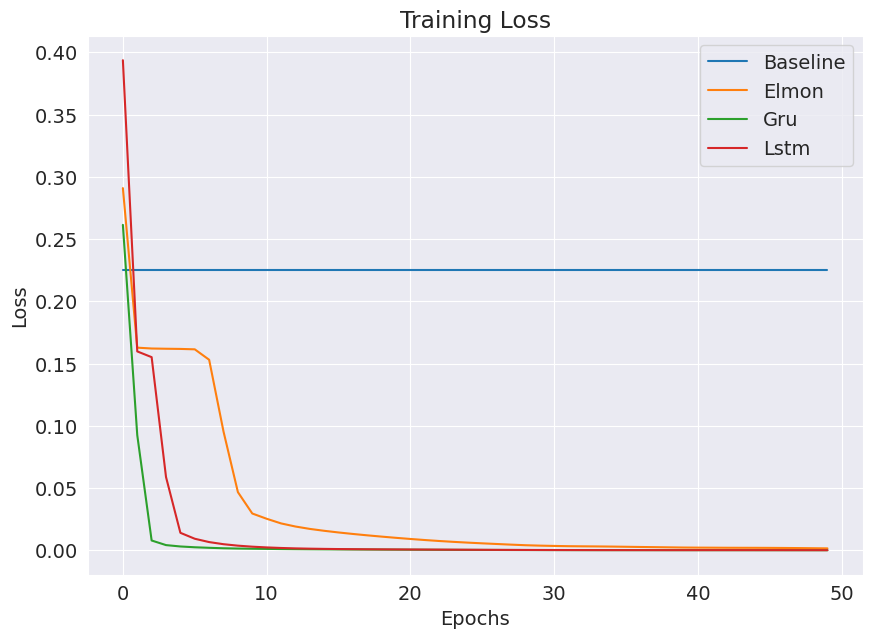

In [44]:
fig = plt.figure()
base = [train_loss for _ in range(EPOCHS)]
plt.plot(base, label='Baseline')
for kind in KINDS:
    plt.plot(exp_stats[kind]["Tloss"], label = kind.capitalize())
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

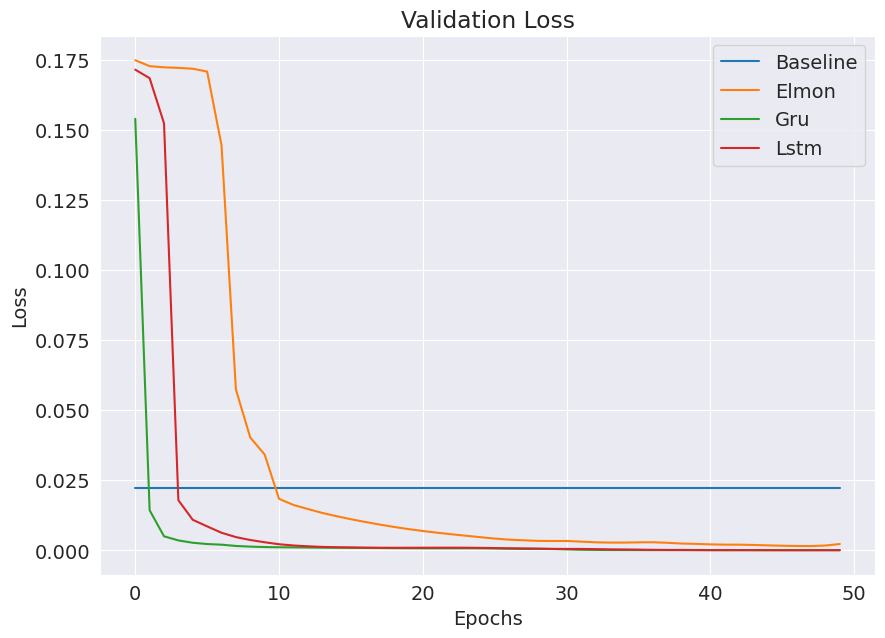

In [45]:
fig = plt.figure()
base = [val_loss for _ in range(EPOCHS)]
plt.plot(base, label='Baseline')
for kind in KINDS:
    plt.plot(exp_stats[kind]["Vloss"], label = kind.capitalize())
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()
plt.show()

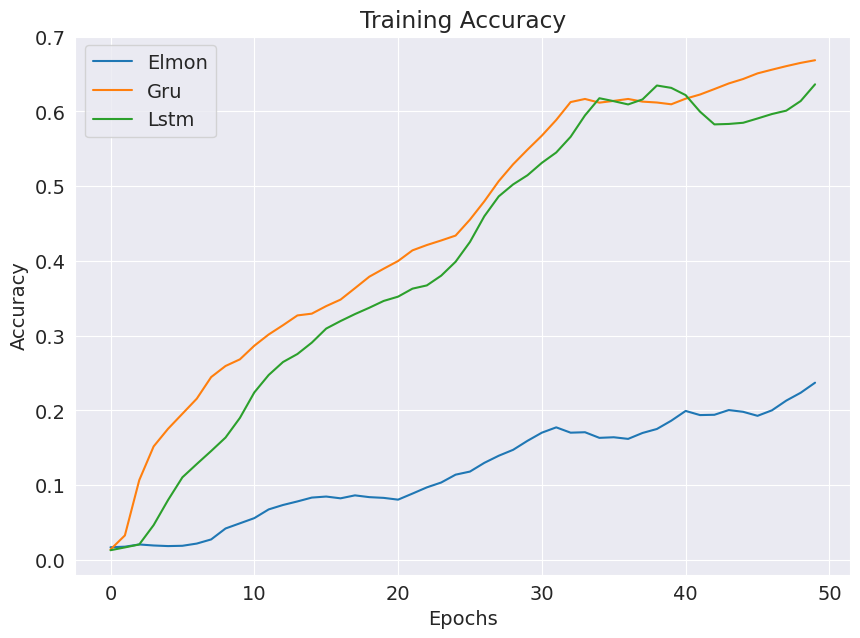

In [46]:
fig = plt.figure()
for kind in KINDS:
    plt.plot(exp_stats[kind]["Tacc"], label = kind.capitalize())
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.show()

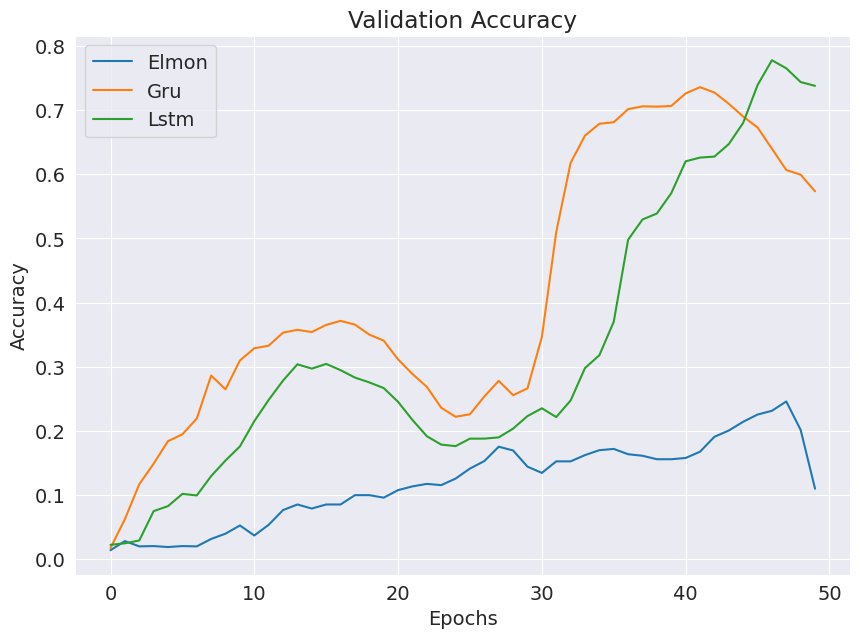

In [47]:
fig = plt.figure()
for kind in KINDS:
    plt.plot(exp_stats[kind]["Vacc"], label = kind.capitalize())
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

In [48]:
def test(model: nn.Module, criterion: nn.Module, testloader: DataLoader[Dataset[float]]):
    losses = 0
    accuracies = 0
    ts_size = testloader.__len__()
    model.train(False)
    for input, target in tqdm(testloader, desc=f'Test: '):
        pred = model(input)
        loss = criterion(pred.squeeze(1), target)
        losses += loss.item()/ts_size
        accuracies += accuracy(pred, target, tol=0.05)/ts_size
    print(f"Test:-> Loss: {losses} Accuracy: {accuracies}")

In [49]:
for kind in KINDS:
    print()
    print(f" Test Results for {kind}")
    test(model=models[kind], criterion=criterion, testloader=test_loader)


 Test Results for elmon


Test: 100%|██████████| 24/24 [00:00<00:00, 75.38it/s]


Test:-> Loss: 0.0023078622665101034 Accuracy: 0.7384672619047618

 Test Results for gru


Test: 100%|██████████| 24/24 [00:00<00:00, 176.80it/s]


Test:-> Loss: 0.00014240496329875898 Accuracy: 0.9986979166666663

 Test Results for lstm


Test: 100%|██████████| 24/24 [00:00<00:00, 297.04it/s]

Test:-> Loss: 0.0001153589597985653 Accuracy: 0.9980468749999997


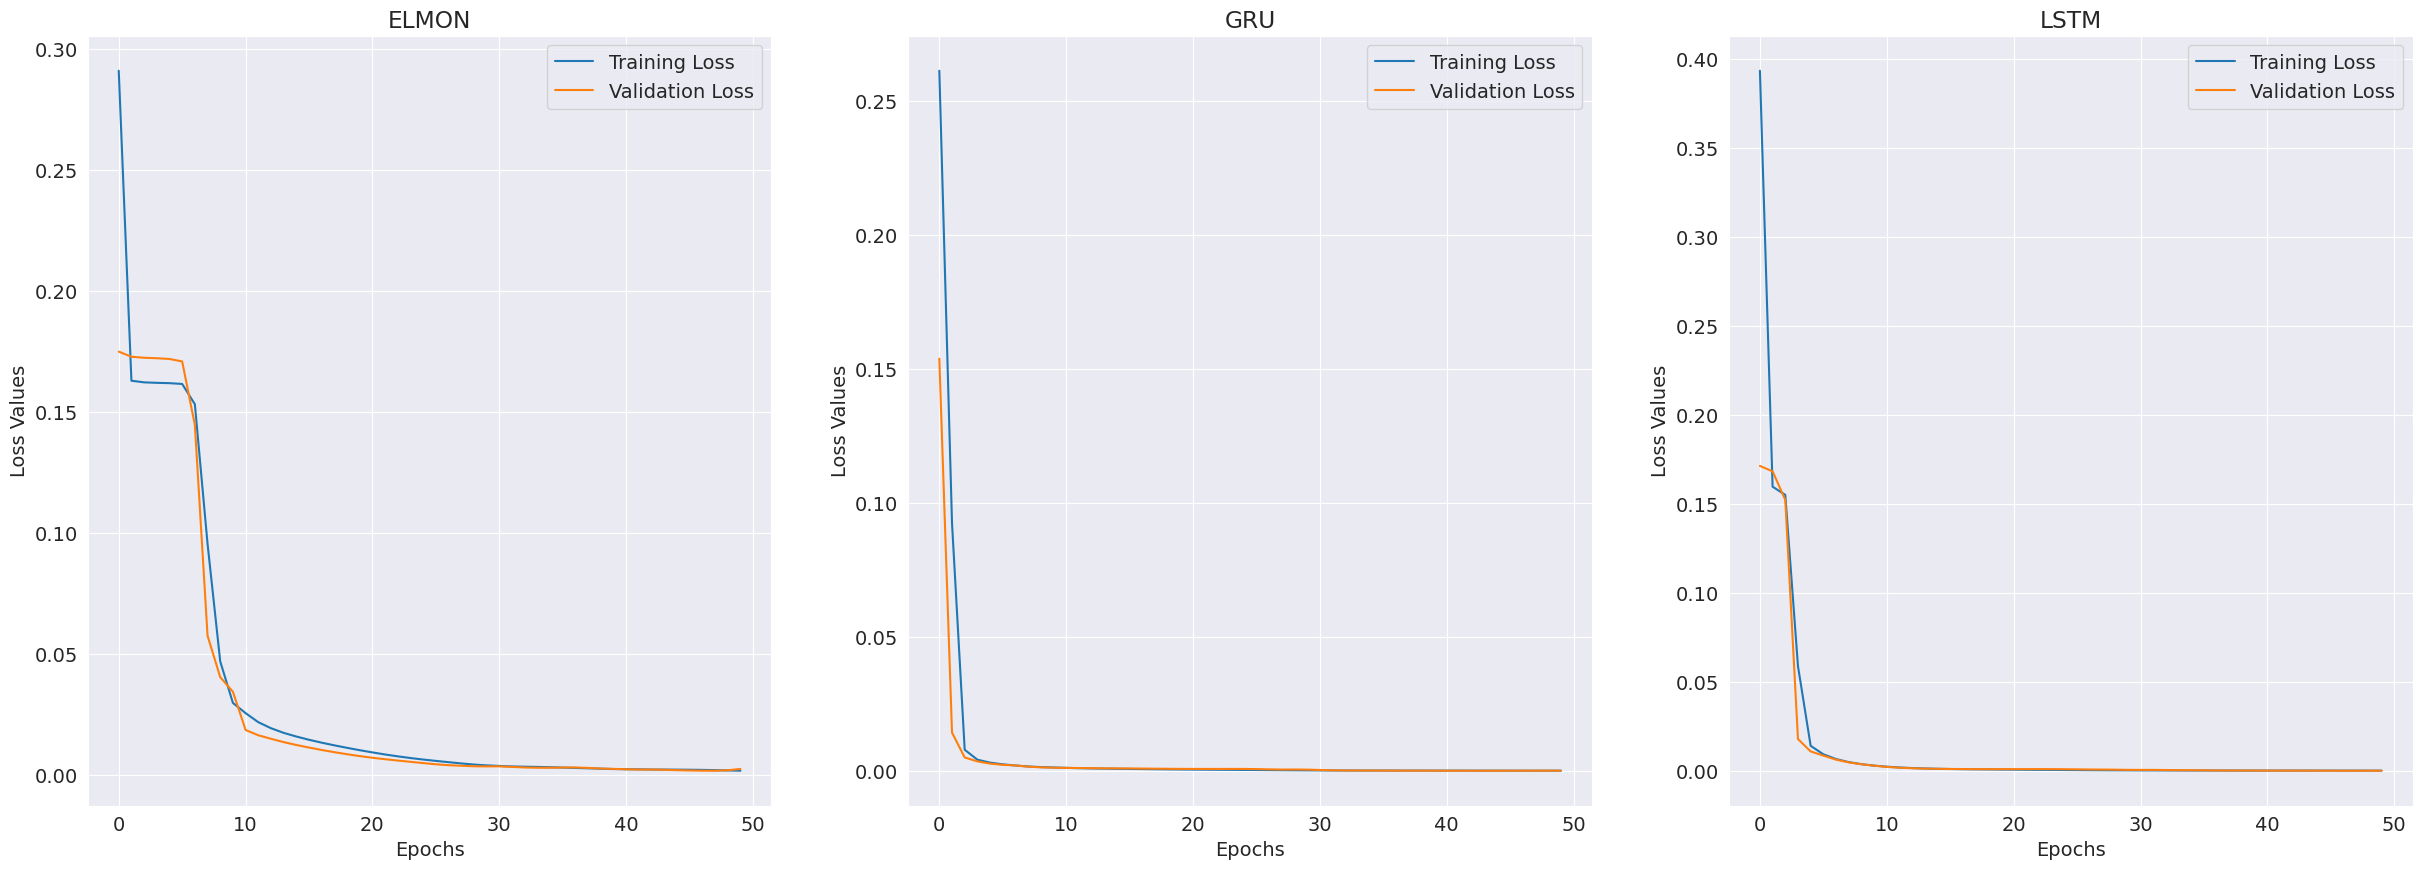

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
for i, kind in enumerate(KINDS):
    axes[i].plot(exp_stats[kind]["Tloss"], label = 'Training Loss')
    axes[i].plot(exp_stats[kind]["Vloss"], label = 'Validation Loss')
    axes[i].legend()
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("Loss Values")
    axes[i].set_title(kind.upper())
plt.show()